In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('viettri_quality.csv')
df1=df.reset_index()['pm25']

In [3]:
df1.shape

(1920,)

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [6]:
print(train_size)
print(test_size)

1728
192


In [7]:
print(train_data.shape)
print(test_data.shape)


(1728, 1)
(192, 1)


In [8]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)


(1627, 100)
(1627,)
(91, 100)
(91,)


In [11]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [12]:
print(X_train.shape)
print(X_test.shape)

(1627, 100, 1)
(91, 100, 1)


In [13]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - loss: 0.0417 - val_loss: 0.0118
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0222 - val_loss: 0.0111
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0221 - val_loss: 0.0102
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0209 - val_loss: 0.0119
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0203 - val_loss: 0.0096
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0187 - val_loss: 0.0097
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0196 - val_loss: 0.0098
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0191 - val_loss: 0.0098
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0203 - val_loss: 0.0096
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0189 - val_loss: 0.0103
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0190 - val_loss: 0.0095
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/st

In [15]:
# 10. Dự báo dữ liệu test,
train_predict=model.predict(X_train)
y_pred=model.predict(test_data.reshape(test_data.shape[0],test_data.shape[1] , 1))


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


In [16]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)


In [17]:
ytest=scaler.inverse_transform(test_data)
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(ytest - y_pred)/np.abs(ytest))*100

print('Testing MAPE:', test_mape)

# Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 12.996630546022647
Testing MAPE: 25.332236870044696
Testing MAE: 10.324028298258781


In [18]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape

(1, 132)

In [19]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=132
i=0
while(i<90):

    if(len(temp_input)>132):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


(1, 132)
[0.15751888]
133
1 day input [0.         0.29378531 0.29943503 0.32768362 0.35028249 0.24858757
 0.28248588 0.38418079 0.21468927 0.17514124 0.25988701 0.32768362
 0.27683616 0.31638418 0.44067797 0.36158192 0.13559322 0.13559322
 0.29378531 0.13559322 0.26553672 0.27118644 0.24293785 0.2259887
 0.40677966 0.36158192 0.28248588 0.27683616 0.42372881 0.38983051
 0.28813559 0.27683616 0.07909605 0.07909605 0.16949153 0.08474576
 0.20338983 0.11864407 0.10734463 0.19774011 0.45762712 0.36723164
 0.4519774  0.61581921 0.42937853 0.6440678  0.59887006 0.16949153
 0.13559322 0.39548023 0.36723164 0.13559322 0.32768362 0.3559322
 0.44067797 0.3559322  0.16384181 0.13559322 0.28813559 0.47457627
 0.32768362 0.31638418 0.30508475 0.25988701 0.42372881 0.28813559
 0.23728814 0.30508475 0.4180791  0.46327684 0.36158192 0.38983051
 0.43502825 0.28813559 0.23728814 0.28248588 0.1299435  0.16949153
 0.4180791  0.40112994 0.29943503 0.25988701 0.33898305 0.33333333
 0.23163842 0.30508475 0.3

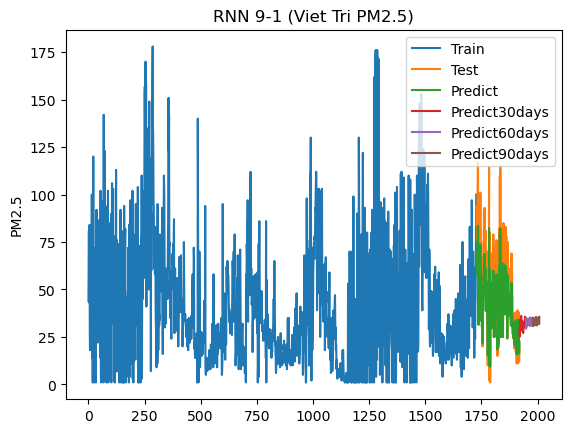

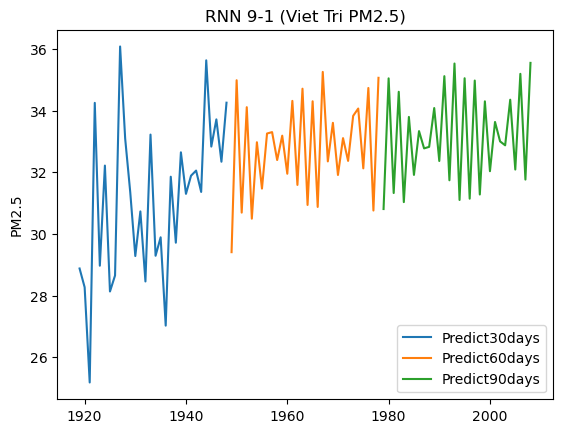

In [20]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Train','Test','Predict','Predict30days', 'Predict60days', 'Predict90days'])
plt.title('RNN 9-1 (Viet Tri PM2.5)')
plt.ylabel('PM2.5')
plt.show()

# 14.Vẽ hình
# Dự đoán 90 ngày tiếp theo

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Predict30days', 'Predict60days', 'Predict90days'])
plt.title('RNN 9-1 (Viet Tri PM2.5)')
plt.ylabel('PM2.5')
plt.show()

In [21]:
print(scaler.inverse_transform(lst_output))

[[28.88084151]
 [28.27308375]
 [25.18363109]
 [34.25306575]
 [28.97105739]
 [32.218945  ]
 [28.13470702]
 [28.65320104]
 [36.08193055]
 [33.0947419 ]
 [31.35716644]
 [29.28493901]
 [30.73236248]
 [28.46005915]
 [33.22402978]
 [29.29426259]
 [29.89152835]
 [27.02740571]
 [31.85770169]
 [29.71728419]
 [32.64879774]
 [31.3014043 ]
 [31.89103185]
 [32.05677269]
 [31.36449079]
 [35.63238883]
 [32.83525883]
 [33.71682395]
 [32.3439654 ]
 [34.25867572]
 [29.41049218]
 [34.98676968]
 [30.69313222]
 [34.11265287]
 [30.4965141 ]
 [32.97580358]
 [31.47247291]
 [33.2587077 ]
 [33.30436292]
 [32.39807118]
 [33.18830213]
 [31.95412625]
 [34.31717032]
 [31.59124769]
 [34.71268538]
 [30.94131622]
 [34.3047213 ]
 [30.87729605]
 [35.25686079]
 [32.35454707]
 [33.60552913]
 [31.91422343]
 [33.10971238]
 [32.37158799]
 [33.8311519 ]
 [34.06928173]
 [32.12832822]
 [34.73588224]
 [30.76102953]
 [35.06540163]
 [30.80935918]
 [35.04816289]
 [31.32834114]
 [34.6125261 ]
 [31.03403245]
 [33.79671399]
 [31.91644